
--- Fold 1/5 ---
Epoch 1/5 - Loss: 0.5590 - Validation Accuracy: 72.97%
Epoch 2/5 - Loss: 0.5461 - Validation Accuracy: 73.03%
Epoch 3/5 - Loss: 0.5450 - Validation Accuracy: 72.99%
Epoch 4/5 - Loss: 0.5437 - Validation Accuracy: 73.11%
Epoch 5/5 - Loss: 0.5425 - Validation Accuracy: 72.79%
Saved model file: best_model_epoch5_fold1_ValidationAccuracy0.731.pth
Test Fold 1: Test Accuracy: 72.90%, F1 Score: 0.696, Precision: 0.792, Recall: 0.621, AUC: 0.796


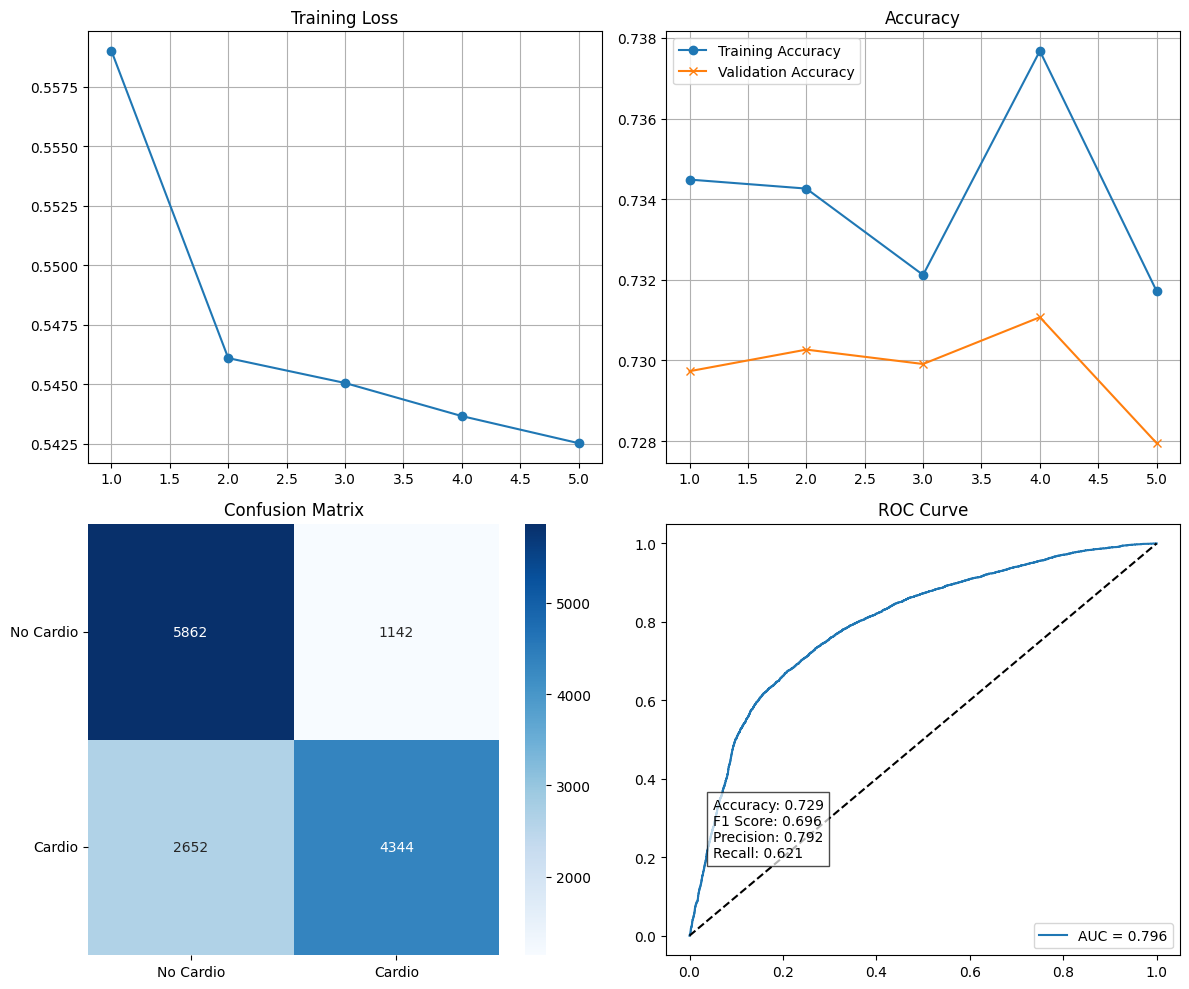


--- Fold 2/5 ---
Epoch 1/5 - Loss: 0.5622 - Validation Accuracy: 73.58%
Epoch 2/5 - Loss: 0.5483 - Validation Accuracy: 73.95%
Epoch 3/5 - Loss: 0.5464 - Validation Accuracy: 73.45%
Epoch 4/5 - Loss: 0.5453 - Validation Accuracy: 73.30%
Epoch 5/5 - Loss: 0.5446 - Validation Accuracy: 73.27%
Saved model file: best_model_epoch5_fold2_ValidationAccuracy0.739.pth
Test Fold 2: Test Accuracy: 72.96%, F1 Score: 0.698, Precision: 0.790, Recall: 0.624, AUC: 0.797


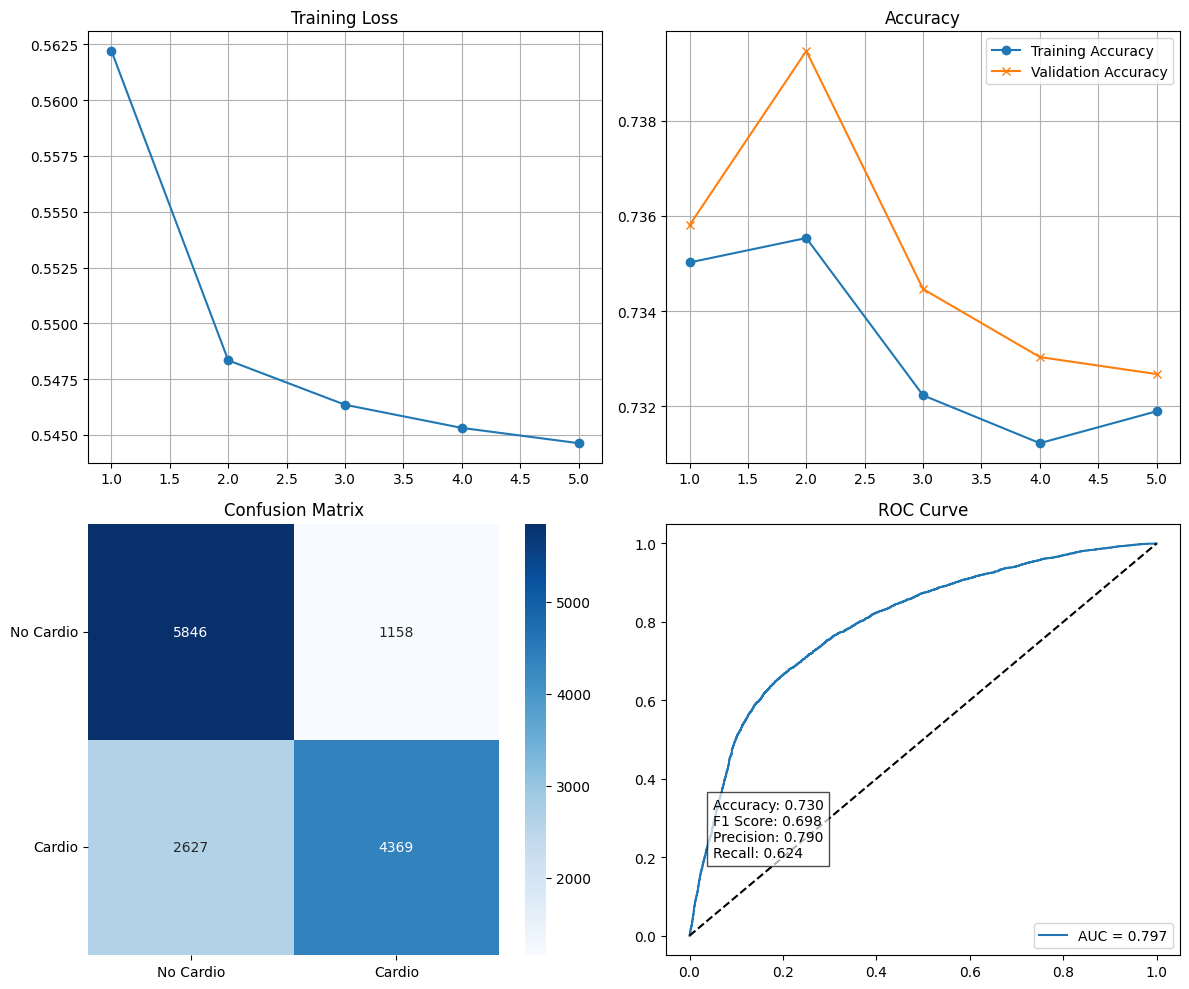


--- Fold 3/5 ---
Epoch 1/5 - Loss: 0.5631 - Validation Accuracy: 73.18%
Epoch 2/5 - Loss: 0.5488 - Validation Accuracy: 73.46%
Epoch 3/5 - Loss: 0.5470 - Validation Accuracy: 73.09%
Epoch 4/5 - Loss: 0.5456 - Validation Accuracy: 72.25%
Epoch 5/5 - Loss: 0.5445 - Validation Accuracy: 73.61%
Saved model file: best_model_epoch5_fold3_ValidationAccuracy0.736.pth
Test Fold 3: Test Accuracy: 73.27%, F1 Score: 0.717, Precision: 0.761, Recall: 0.678, AUC: 0.798


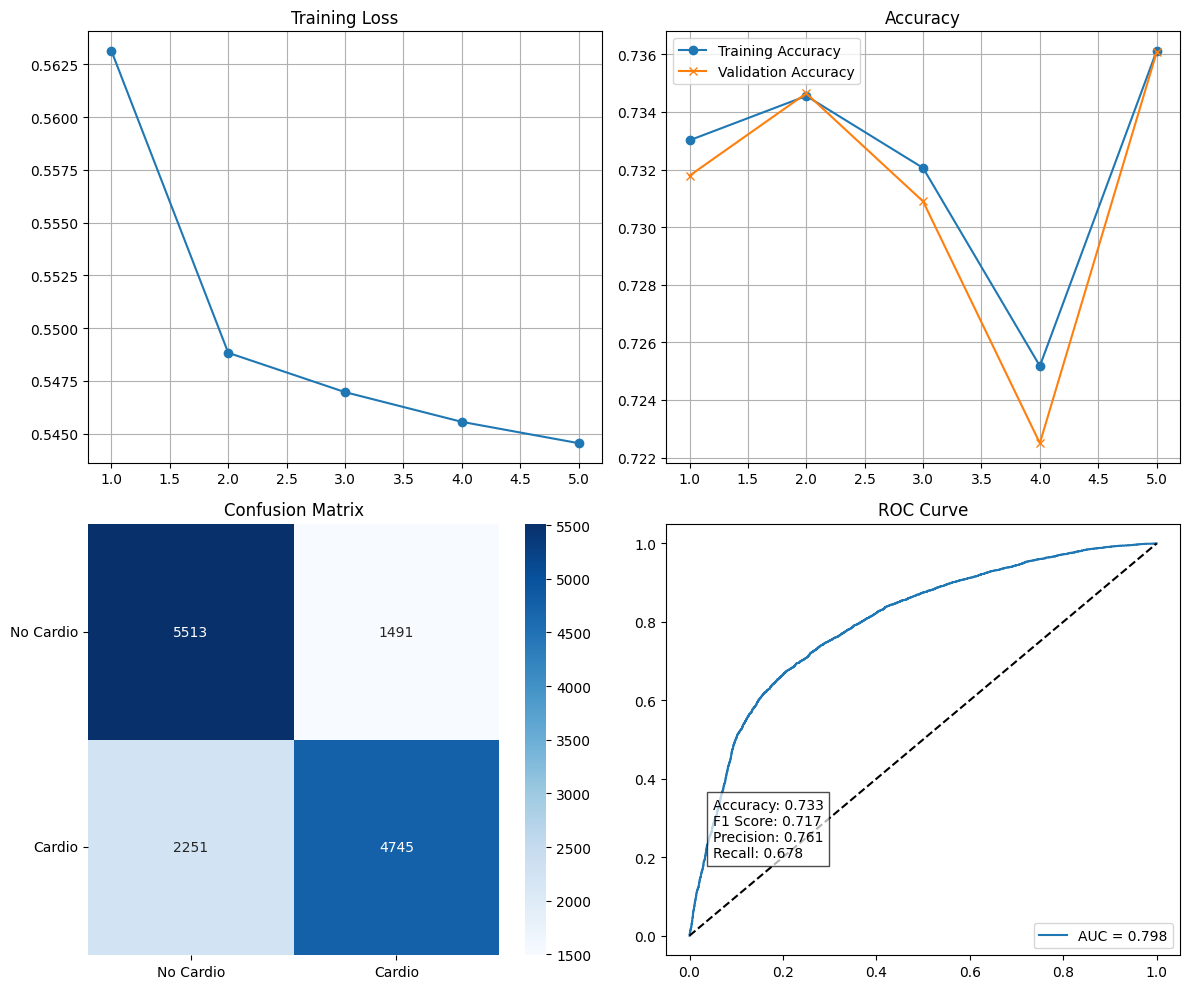


--- Fold 4/5 ---
Epoch 1/5 - Loss: 0.5618 - Validation Accuracy: 73.13%
Epoch 2/5 - Loss: 0.5484 - Validation Accuracy: 72.55%
Epoch 3/5 - Loss: 0.5449 - Validation Accuracy: 73.27%
Epoch 4/5 - Loss: 0.5440 - Validation Accuracy: 72.89%
Epoch 5/5 - Loss: 0.5435 - Validation Accuracy: 73.45%
Saved model file: best_model_epoch5_fold4_ValidationAccuracy0.734.pth
Test Fold 4: Test Accuracy: 72.99%, F1 Score: 0.726, Precision: 0.735, Recall: 0.718, AUC: 0.797


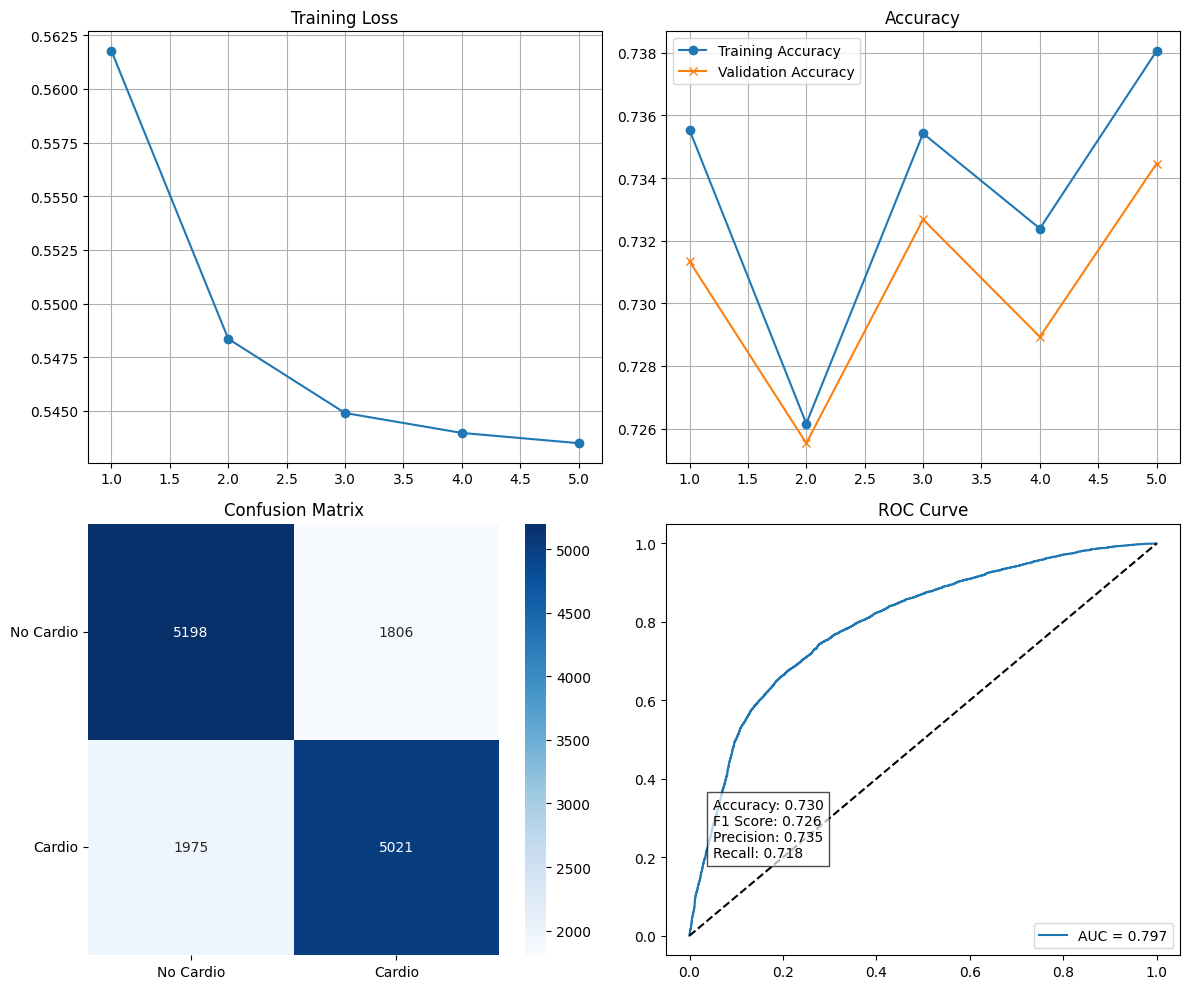


--- Fold 5/5 ---
Epoch 1/5 - Loss: 0.5640 - Validation Accuracy: 73.41%
Epoch 2/5 - Loss: 0.5490 - Validation Accuracy: 72.86%
Epoch 3/5 - Loss: 0.5479 - Validation Accuracy: 73.46%
Epoch 4/5 - Loss: 0.5454 - Validation Accuracy: 72.82%
Epoch 5/5 - Loss: 0.5446 - Validation Accuracy: 73.74%
Saved model file: best_model_epoch5_fold5_ValidationAccuracy0.737.pth
Test Fold 5: Test Accuracy: 72.96%, F1 Score: 0.723, Precision: 0.741, Recall: 0.705, AUC: 0.797


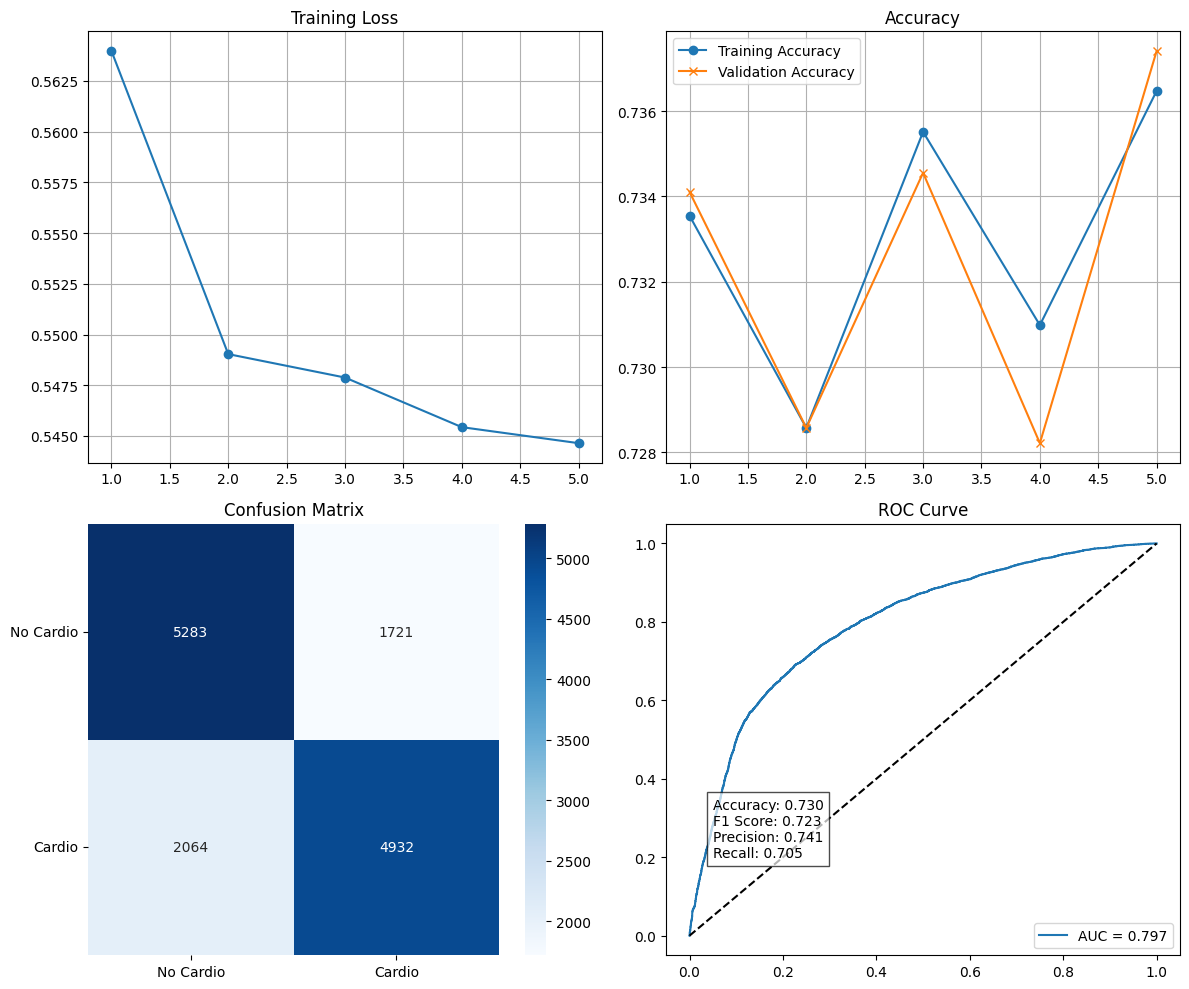

Average test results: Test Accuracy: 73.02%, F1 Score: 0.712, AUC: 0.797, Recall: 0.669


In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score,
    recall_score, roc_auc_score, roc_curve, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
from fttransformer import FTTransformer

# --------------------------------------------
# 設定
# --------------------------------------------
DATA_PATH = "/home/osajima/ドキュメント/program/Transformer_Study/fttransformer_pytorch/cardio_train.csv"
TEST_RATIO = 0.2
K_FOLDS = 5
EPOCHS = 5
BATCH_SIZE = 128
LR = 3e-4

# 保存ディレクトリ
SAVE_DIR = os.path.join(os.getcwd(), "save_models3")
IMAGE_DIR = os.path.join(os.getcwd(), "save_confusion_matrix_image3")
os.makedirs(SAVE_DIR, exist_ok=True)
os.makedirs(IMAGE_DIR, exist_ok=True)

# --------------------------------------------
# データ読み込み・前処理
# --------------------------------------------
data = pd.read_csv(DATA_PATH, sep=';')
data.drop(columns=["id"], inplace=True)
X = data.drop(columns=["cardio"])
y = data["cardio"]

categorical_cols = ["gender","cholesterol","gluc","smoke","alco","active"]
continuous_cols = ["age","height","weight","ap_hi","ap_lo"]
for col in categorical_cols:
    X[col] = LabelEncoder().fit_transform(X[col])
X[continuous_cols] = StandardScaler().fit_transform(X[continuous_cols])

# テストセット分離
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=TEST_RATIO, random_state=42, stratify=y
)

# DataLoader ヘルパー
class CardioDataset(Dataset):
    def __init__(self, X, y):
        self.X_cat = torch.tensor(X[categorical_cols].values, dtype=torch.long)
        self.X_cont = torch.tensor(X[continuous_cols].values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X_cat[idx], self.X_cont[idx], self.y[idx]

def get_loader(X, y, shuffle=False):
    return DataLoader(CardioDataset(X, y), batch_size=BATCH_SIZE, shuffle=shuffle)

test_loader = get_loader(X_test, y_test)

def plot_all_metrics(train_losses, train_accs, val_accs,
                    y_true, y_pred, y_prob,
                    fold, val_acc, test_acc, save_dir):
    cm = confusion_matrix(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc = roc_auc_score(y_true, y_prob)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    axs[0, 0].plot(range(1, len(train_losses) + 1), train_losses, 'o-')
    axs[0, 0].set_title("Training Loss")
    axs[0, 0].grid(True)

    axs[0, 1].plot(range(1, len(train_accs) + 1), train_accs, 'o-', label='Training Accuracy')
    axs[0, 1].plot(range(1, len(val_accs) + 1), val_accs, 'x-', label='Validation Accuracy')
    axs[0, 1].set_title("Accuracy")
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axs[1, 0])
    axs[1, 0].set_title("Confusion Matrix")
    axs[1, 0].set_xticklabels(['No Cardio', 'Cardio'])
    axs[1, 0].set_yticklabels(['No Cardio', 'Cardio'], rotation=0)

    axs[1, 1].plot(fpr, tpr, label=f'AUC = {auc:.3f}')
    axs[1, 1].plot([0, 1], [0, 1], 'k--')
    axs[1, 1].set_title('ROC Curve')
    axs[1, 1].legend(loc='lower right')
    axs[1, 1].text(0.05, 0.2,
                f"Accuracy: {acc:.3f}\nF1 Score: {f1:.3f}\nPrecision: {prec:.3f}\nRecall: {rec:.3f}",
                bbox=dict(facecolor='white', alpha=0.7))

    fig.tight_layout()
    # 保存ファイル名を省略せず作成
    fname = (
        f"confusion_matrix_Epoch{EPOCHS}_Fold{fold}_ValAcc{val_acc:.3f}"
        f"_TestAccuracy{test_acc:.3f}.png"
    )
    save_path = os.path.join(save_dir, fname)
    fig.savefig(save_path, dpi=200, bbox_inches='tight')
    plt.show()
    plt.close(fig)

# K-Fold CV
kf = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fold_results = []

for fold, (tr, va) in enumerate(kf.split(X_train_val, y_train_val), 1):
    print(f"\n--- Fold {fold}/{K_FOLDS} ---")
    X_tr, y_tr = X_train_val.iloc[tr], y_train_val.iloc[tr]
    X_va, y_va = X_train_val.iloc[va], y_train_val.iloc[va]
    train_loader = get_loader(X_tr, y_tr, True)
    val_loader = get_loader(X_va, y_va)

    model = FTTransformer(
        categories=[X[c].nunique() for c in categorical_cols],
        num_continuous=len(continuous_cols), dim=64, depth=6, heads=8,
        ff_dropout=0.2, attn_dropout=0.2
    ).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=LR)
    criterion = nn.BCEWithLogitsLoss()

    best_val_acc = 0.0
    best_state = None
    train_losses, train_accs, val_accs = [], [], []

    for epoch in range(1, EPOCHS + 1):
        model.train()
        total_loss = 0.0
        for x_cat, x_cont, labels in train_loader:
            x_cat, x_cont, labels = x_cat.to(device), x_cont.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(x_cat, x_cont)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        model.eval()
        tc, tt = 0, 0
        with torch.no_grad():
            for x_cat, x_cont, labels in train_loader:
                preds = (torch.sigmoid(model(x_cat.to(device), x_cont.to(device))) > 0.5).float()
                tc += (preds.cpu() == labels).sum().item()
                tt += labels.size(0)
        train_accs.append(tc / tt)

        preds, probs, labs = [], [], []
        with torch.no_grad():
            for x_cat, x_cont, labels in val_loader:
                pr = torch.sigmoid(model(x_cat.to(device), x_cont.to(device))).cpu().numpy()
                preds.extend((pr > 0.5).astype(int).flatten())
                probs.extend(pr.flatten())
                labs.extend(labels.numpy())
        val_acc = accuracy_score(labs, preds)
        val_accs.append(val_acc)

        # Lossと百分率表示
        print(f"Epoch {epoch}/{EPOCHS} - Loss: {avg_loss:.4f} - Validation Accuracy: {val_acc*100:.2f}%")
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = model.state_dict().copy()

    # モデル保存
    model_name = (
        f"best_model_epoch{EPOCHS}_fold{fold}_ValAcc{best_val_acc:.3f}.pth"
    )
    model_path = os.path.join(SAVE_DIR, model_name)
    torch.save(best_state, model_path)
    print(f"Saved model file: {model_name}")

    # テスト評価
    best_model = FTTransformer(
        categories=[X[c].nunique() for c in categorical_cols],
        num_continuous=len(continuous_cols), dim=64, depth=6, heads=8,
        ff_dropout=0.2, attn_dropout=0.2
    ).to(device)
    best_model.load_state_dict(torch.load(model_path))
    best_model.eval()

    y_t, y_p, y_pr = [], [], []
    with torch.no_grad():
        for x_cat, x_cont, labels in test_loader:
            pr = torch.sigmoid(best_model(x_cat.to(device), x_cont.to(device))).cpu().numpy()
            y_p.extend((pr > 0.5).astype(int).flatten())
            y_pr.extend(pr.flatten())
            y_t.extend(labels.numpy())
    test_acc = accuracy_score(y_t, y_p)
    f1s = f1_score(y_t, y_p)
    prec = precision_score(y_t, y_p)
    rec = recall_score(y_t, y_p)
    auc_val = roc_auc_score(y_t, y_pr)
    print(f"Test Fold {fold}: Test Accuracy: {test_acc*100:.2f}%, F1 Score: {f1s:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, AUC: {auc_val:.3f}")

    # プロット・保存
    plot_all_metrics(
        train_losses, train_accs, val_accs,
        y_t, y_p, y_pr,
        fold, best_val_acc, test_acc, IMAGE_DIR
    )
    fold_results.append((test_acc, f1s, auc_val, rec))

# 平均結果表示
avg = [np.mean([r[i] for r in fold_results]) for i in range(4)]
print(f"Average test results: Test Accuracy: {avg[0]*100:.2f}%, F1 Score: {avg[1]:.3f}, AUC: {avg[2]:.3f}, Recall: {avg[3]:.3f}")
